### Test pyro model with simulations

In [42]:
# TO REMOVE when notebook is stable

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import pyro.distributions as dist
from pyro.distributions.torch_distribution import TorchDistribution
from tissue_purifier.genex.pyro_model_from_scratch import *
from tissue_purifier.genex.gene_utils import *

import numpy
import numpy as np
import torch
import seaborn
import tarfile
import os
import matplotlib
import matplotlib.pyplot as plt
from anndata import read_h5ad
import scanpy as sc
import pandas as pd

from torch.distributions.poisson import Poisson 


In [44]:
# rng = torch.Generator()
# seed = 142
# rng.manual_seed(seed)
# torch.randn((5,2), generator=rng)
# x = torch.random.get_rng_state()

In [45]:
# torch.randn((5,2), generator=rng)
# y = torch.random.get_rng_state()
# print(sum(x != y))

In [46]:
## set parameters for simulation

k = 5
n = 1000 * k
g = 10
nUmis = 10000
l = k # k #same b/c ncv

use_covariates_generate = True

In [47]:
## simulate fake counts

beta0_k1g = dist.Normal(-2, 1).sample((k,g))[:, None, :]

## normalize beta0s so they add up to 1 for each cell-type across all genes **?
## logsumexp to renormalize
beta0_k1g_norm = beta0_k1g - torch.logsumexp(beta0_k1g, dim=-1, keepdim=True)

total_umi_n1 = torch.tensor(nUmis).expand((n,1)).float()
total_umi_n11 = total_umi_n1[..., None]


# sample fake ncv vectors
prob = np.array([0.75])
ncv_n1l = dist.Dirichlet(torch.tensor(np.repeat(prob,[l]))).sample((n,1))
#ncv_n1l = torch.ones((n,1,l))

#print(ncv_n1l)
ncv_nl = torch.squeeze(ncv_n1l, 1)
ncv_nl1 = ncv_nl.unsqueeze(dim=-1)

## sample fake covariates
beta_klg = dist.Normal(0,1).sample((k,l,g))

## mean centering beta ##
#mean = torch.mean(beta_klg, dim=-2)
#mean = einops.repeat(mean, 'k g -> k l g', l=l)
#beta_klg = beta_klg - mean

#beta_klg = 2*torch.ones((k,l,g))
#beta_klg = beta_klg - torch.mean(beta_klg, dim=-2)
## add in sparsity + regularization later


cell_ids_n = (torch.rand((n))*k).int().long() ##randint instead
#beta0_n1g = beta0_k1g_norm[cell_ids_n]
beta0_n1g = beta0_k1g[cell_ids_n]
beta_nlg = beta_klg[cell_ids_n]

#print(beta_klg)
#print(torch.sum(ncv_nl1 * beta_nlg, dim=-2, keepdim=True))

if use_covariates_generate:
    log_mu_n1g = beta0_n1g + torch.sum(ncv_nl1 * beta_nlg, dim=-2, keepdim=True)
    #log_mu_n1g = torch.sum(ncv_nl1 * beta_nlg, dim=-2, keepdim=True)
else:
    log_mu_n1g = beta0_n1g

log_mu_n1g_norm = log_mu_n1g - torch.logsumexp(log_mu_n1g, dim=-1, keepdim=True) ## normalize across genes so that sum of umis is roughly correct
#log_mu_n1g_norm = log_mu_n1g
sim_counts_n1g = Poisson(rate=total_umi_n11*log_mu_n1g_norm.exp()).sample()



In [48]:
print(sim_counts_n1g.shape)
print(torch.mean(sim_counts_n1g.sum(dim=-1)))
print(beta0_k1g.shape)
print(beta0_n1g.shape)

torch.Size([5000, 1, 10])
tensor(9999.0502, dtype=torch.float64)
torch.Size([5, 1, 10])
torch.Size([5000, 1, 10])


### Fit model

In [49]:
use_covariates_model = True

In [50]:
## look for indexing bugs 

## Create GeneDataset

import anndata
from scipy import sparse

    
counts_ng = np.float32(sim_counts_n1g.squeeze()) ## assume n and g aren't 1
sim_anndata = anndata.AnnData(X=sparse.csr_matrix(counts_ng))
sim_anndata.obs['cell_type'] = cell_ids_n.numpy()
sim_anndata.obsm['ncv'] = np.array(ncv_nl)

## Run GLM

gene_dataset = make_gene_dataset_from_anndata(
        anndata=sim_anndata,
        cell_type_key='cell_type',
        covariate_key = 'ncv',
        preprocess_strategy='raw',
        apply_pca=False)


In [51]:
assert(np.all(np.array(gene_dataset.cell_type_ids) == cell_ids_n.numpy()))

[iter 0]  loss: 288057536.0000
[iter 500]  loss: 10092492.0000
[iter 1000]  loss: 2624418.0000
[iter 1500]  loss: 1181538.6250
[iter 2000]  loss: 666370.4375
[iter 2500]  loss: 464307.5312
[iter 3000]  loss: 381109.1250
[iter 3500]  loss: 324674.6250
[iter 4000]  loss: 289952.0625
[iter 4500]  loss: 279310.1250
[iter 5000]  loss: 271758.5312
Training completed in 16.686842918395996 seconds


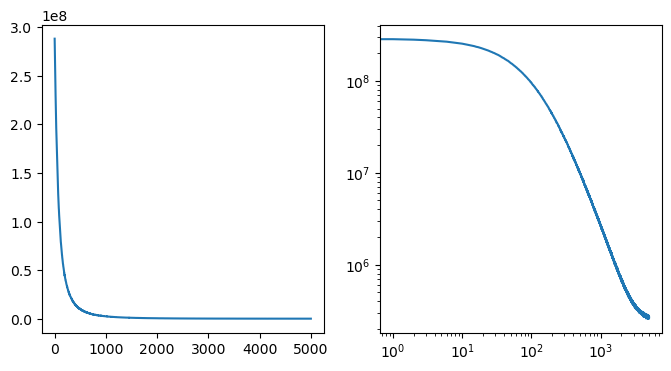

In [52]:
train_dataset, test_dataset, val_dataset = next(iter(train_test_val_split(gene_dataset, random_state=0, train_size=0.8,test_size=0.1,val_size=0.1)))

pyro.clear_param_store()
torch.cuda.empty_cache()
gr_cov = GeneRegression(use_covariates = use_covariates_model)
gr_cov.configure_optimizer(optimizer_type='adam', lr=5e-3)
beta0_k1g_store, beta_klg_store = gr_cov.train(
    dataset=train_dataset,
    n_steps=5000,
    print_frequency=500,
    subsample_size_cells=1000)

fig, axes = plt.subplots(ncols=2, figsize=(8,4))
gr_cov.show_loss(ax=axes[0])
gr_cov.show_loss(ax=axes[1], logy=True, logx=True)

In [53]:
import pyro.poutine as poutine

trace = poutine.trace(gr_cov._model).get_trace(n_cells= n,
           l_cov= l,
           g_genes= g,
           k_cell_types= k,
           use_covariates= use_covariates_model,
           counts_ng= gene_dataset.counts,
           total_umi_n= gene_dataset.counts.sum(dim=-1),
           covariates_nl= gene_dataset.covariates,
           cell_type_ids_n= gene_dataset.cell_type_ids,
           subsample_size_cells=None)
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

Trace Shapes:             
 Param Sites:             
        beta0 5    1 10   
         beta 5    5 10   
Sample Sites:             
   cells dist         |   
        value   5000  |   
     log_prob         |   
  counts dist   5000  | 10
        value   5000  | 10
     log_prob   5000  |   


### Evaluate model fit

In [54]:
## Get fit parameters
pred_beta0_k1g = gr_cov._param_dict["beta0"]

tensor(-1.4566)


Text(0.5, 1.0, 'beta0')

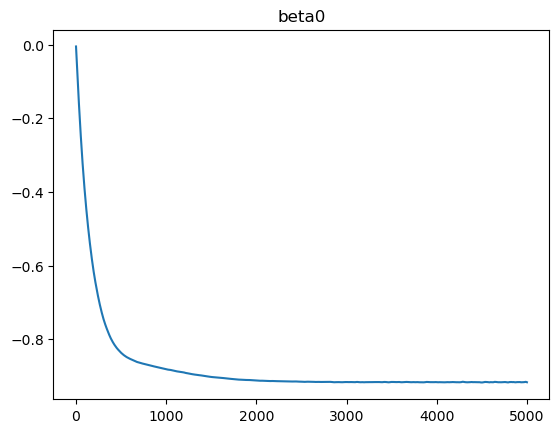

In [55]:
print(beta0_k1g_norm[1, 0, 0])

beta0_inspect = []
for beta0_k1g_temp in beta0_k1g_store:
    beta0_inspect.append(beta0_k1g_temp[1, 0, 0].detach().cpu().numpy())
    
    
plt.plot(beta0_inspect)
plt.title('beta0')

In [56]:
## beta 0 correlation
print("beta0 correlation:")
print(np.corrcoef(beta0_k1g_norm.detach().numpy().flatten(), pred_beta0_k1g.detach().numpy().flatten())[0,1])

beta0 correlation:
0.9116391381186311


In [57]:
# gene_dataset.counts[gene_dataset.cell_type_ids == 0].sum(dim=0)/gene_dataset.counts[gene_dataset.cell_type_ids == 0].sum(dim=0).sum()
# gene_dataset.counts[gene_dataset.cell_type_ids == 1].sum(dim=0)/gene_dataset.counts[gene_dataset.cell_type_ids == 1].sum(dim=0).sum()

Text(0, 0.5, 'predicted parameter value')

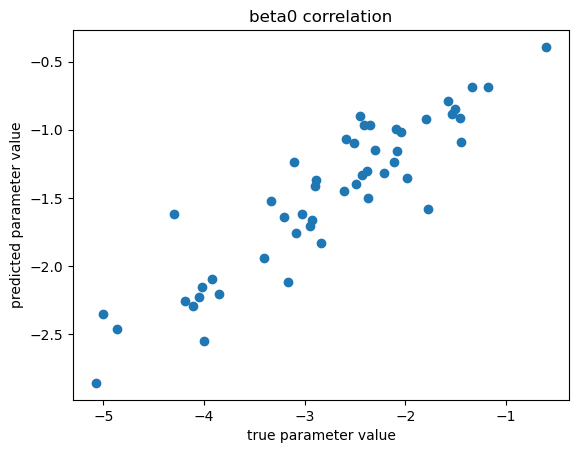

In [58]:
plt.scatter(beta0_k1g_norm.detach().numpy().flatten(), pred_beta0_k1g.detach().numpy().flatten())
plt.title('beta0 correlation')
plt.xlabel('true parameter value')
plt.ylabel('predicted parameter value')

### repeat for beta

In [59]:
## Get fit parameters
pred_beta_klg = gr_cov._param_dict["beta"]

tensor(-0.4485)


Text(0.5, 1.0, 'beta')

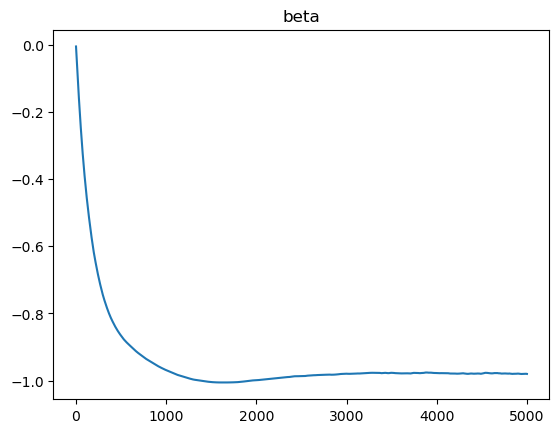

In [60]:
print(beta_klg[1, 0, 0])

beta_inspect = []
for beta_klg_temp in beta_klg_store:
    beta_inspect.append(beta_klg_temp[1, 0, 0].detach().numpy())
    
    
plt.plot(beta_inspect)
plt.title('beta')

In [61]:
## beta correlation
print("beta correlation:")
print(np.corrcoef(beta_klg.detach().numpy().flatten(), pred_beta_klg.detach().numpy().flatten())[0,1])

beta correlation:
0.8005146939854729


Text(0, 0.5, 'predicted parameter value')

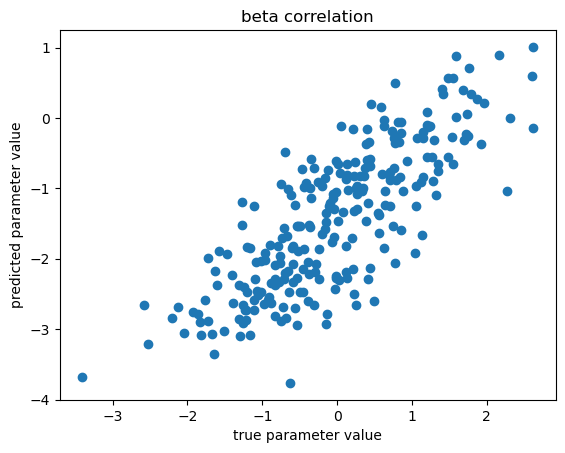

In [62]:
plt.scatter(beta_klg.detach().numpy().flatten(), pred_beta_klg.detach().numpy().flatten())
plt.title('beta correlation')
plt.xlabel('true parameter value')
plt.ylabel('predicted parameter value')

### compare model prediction to true values

Text(0, 0.5, 'predicted counts')

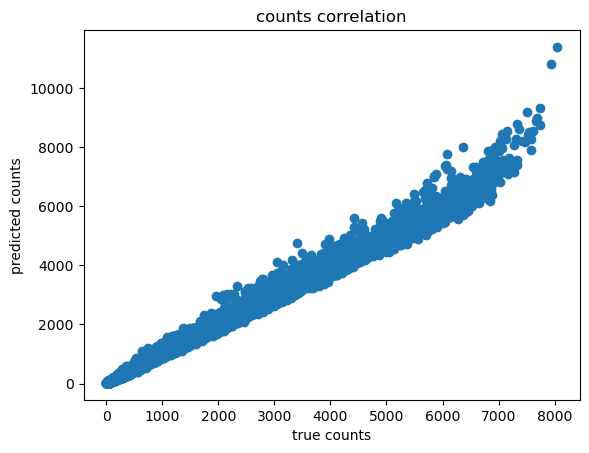

In [63]:
pred_counts_ng, q_ng = gr_cov.predict(train_dataset, 
                         num_samples = 10)

plt.scatter(train_dataset.counts.flatten(), pred_counts_ng.detach().numpy().flatten())
plt.title('counts correlation')
plt.xlabel('true counts')
plt.ylabel('predicted counts')

In [64]:
print("counts correlation:")
print(np.corrcoef(train_dataset.counts.flatten(), pred_counts_ng.detach().numpy().flatten())[0,1])

counts correlation:
0.9958517328711664


Text(0, 0.5, 'predicted counts')

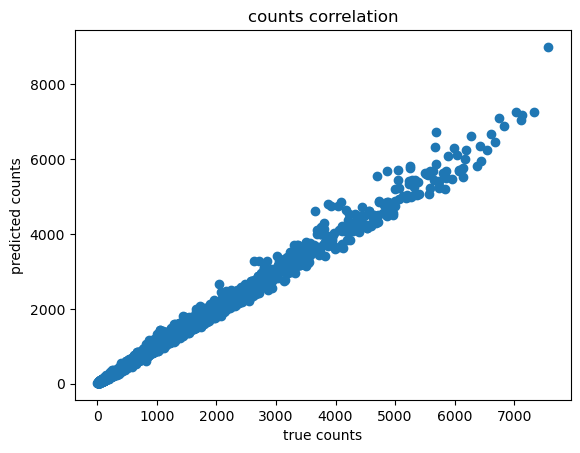

In [65]:
## predict on val dataset 

pred_val_counts_ng, q_val_ng = gr_cov.predict(val_dataset, 
                         num_samples = 10)

plt.scatter(val_dataset.counts.flatten(), pred_val_counts_ng.detach().numpy().flatten())
plt.title('counts correlation')
plt.xlabel('true counts')
plt.ylabel('predicted counts')

In [66]:
print("counts correlation:")
print(np.corrcoef(val_dataset.counts.flatten(), pred_val_counts_ng.detach().numpy().flatten())[0,1])

counts correlation:
0.9962541548046835


### Train baseline model without covariates

[iter 0]  loss: 287852288.0000
[iter 500]  loss: 33006032.0000
[iter 1000]  loss: 10944824.0000
[iter 1500]  loss: 5947276.5000
[iter 2000]  loss: 4312857.0000
[iter 2500]  loss: 3800131.5000
[iter 3000]  loss: 3403188.0000
[iter 3500]  loss: 3345832.0000
[iter 4000]  loss: 3346498.5000
[iter 4500]  loss: 3375419.7500
[iter 5000]  loss: 3371964.5000
Training completed in 13.316644191741943 seconds


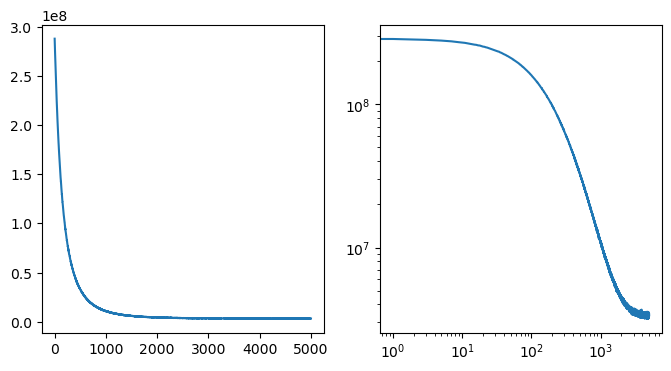

In [67]:
pyro.clear_param_store()
torch.cuda.empty_cache()
gr_baseline = GeneRegression(use_covariates = False)
gr_baseline.configure_optimizer(optimizer_type='adam', lr=5e-3)
beta0_k1g_store, beta_klg_store = gr_baseline.train(
    dataset=train_dataset,
    n_steps=5000,
    use_covariates = False,
    print_frequency=500,
    subsample_size_cells=1000)

fig, axes = plt.subplots(ncols=2, figsize=(8,4))
gr_baseline.show_loss(ax=axes[0])
gr_baseline.show_loss(ax=axes[1], logy=True, logx=True)

q_no_cov_mean:
tensor([[ 844.1000,  117.2000,   91.5000,  ..., 1154.8000,   71.6000,
          654.3000],
        [ 155.2000,  383.2000,   24.2000,  ...,   38.9000,   55.5000,
          503.7000],
        [ 331.4000,  221.3000,   65.3000,  ...,  357.6000,   15.3000,
          520.4000],
        ...,
        [  66.7000,   16.1000,  198.2000,  ...,  290.3000,  917.7000,
          186.8000],
        [ 696.4000,  283.6000,  422.4000,  ...,   34.3000,   73.4000,
           78.8000],
        [ 113.2000,   70.7000,   44.0000,  ..., 1036.7000,   45.1000,
           37.5000]])


Text(0, 0.5, 'predicted counts')

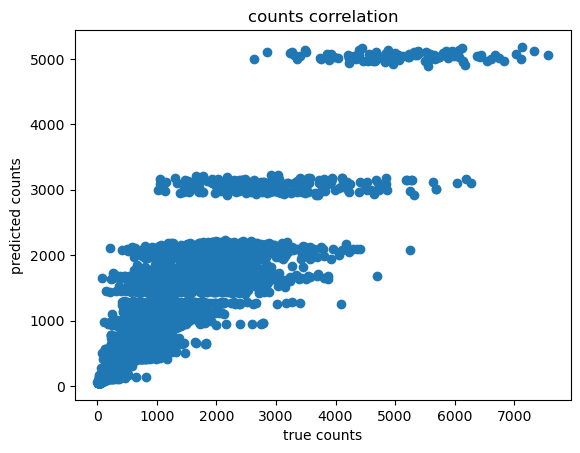

In [68]:
## predict on val dataset 

pred_no_cov_val_counts_ng, q_no_cov_val_ng = gr_baseline.predict(val_dataset, 
                         num_samples = 10)

print("q_no_cov_mean:")
print(q_no_cov_val_ng)

plt.scatter(val_dataset.counts.flatten(), pred_no_cov_val_counts_ng.detach().numpy().flatten())
plt.title('counts correlation')
plt.xlabel('true counts')
plt.ylabel('predicted counts')

In [69]:
print("counts correlation:")
print(np.corrcoef(val_dataset.counts.flatten(), pred_no_cov_val_counts_ng.detach().numpy().flatten())[0,1])

counts correlation:
0.8903757673898065


### Compute q-ratio evaluation metric

In [70]:
pred_no_cov_val_counts_ng, q_no_cov_val_ng = gr_baseline.predict(
    train_dataset,
    num_samples=100,
    subsample_size_cells=1000)

df_baseline_test = gr_baseline.compute_eval_metrics(
    test_dataset,
    num_samples=100,
    subsample_size_cells=1000)

df_baseline_test = df_baseline_test.groupby(["cell_type", "gene"]).mean() 

In [71]:
result_dict = dict()

df_metric_tmp_test, q_z_kg_tmp_test = gr_cov.compute_eval_metrics(
        test_dataset,
        num_samples=100,
        subsample_size_cells=1000,
        gr_baseline = gr_baseline)
    
df_tmp_test = df_metric_tmp_test.groupby(["cell_type", "gene"]).mean()
df_tmp_test["q_ratio"] = df_tmp_test["q_dist"] / df_baseline_test["q_dist"]
result_dict["test_gr_cov"] = df_tmp_test["q_ratio"].values 

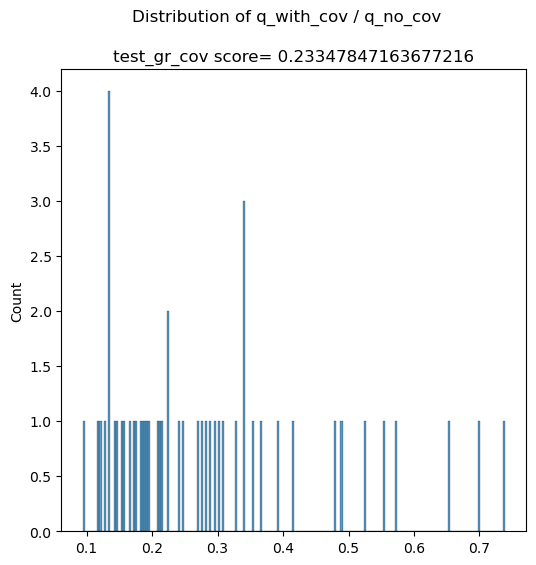

In [72]:
nmax = len(result_dict.keys())
ncols = 1
nrows = int(numpy.ceil(float(nmax)/ncols))

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols, 6*nrows))
fig.suptitle("Distribution of q_with_cov / q_no_cov")
    
score_dict = dict()
    
for n, key in enumerate(result_dict.keys()):
    r,c = n//ncols, n%ncols
    #ax_cur = axes[r,c]
    _ = seaborn.histplot(x=result_dict[key], bins=200)
    score = numpy.median(result_dict[key])
    score_dict[key] = score
    _ = axes.set_title("{} score= {}".format(key, score))

### Compute mad z-score evaluation metric

q_z_mean:
tensor(-0.9948)


(array([[2., 0., 0., 1., 3., 1., 0., 1., 1., 1.],
        [0., 3., 2., 1., 2., 1., 0., 0., 0., 1.],
        [0., 1., 0., 2., 3., 2., 2., 0., 0., 0.],
        [2., 1., 4., 0., 1., 0., 0., 1., 1., 0.],
        [1., 2., 1., 2., 1., 1., 1., 1., 0., 0.]]),
 array([-1.3652202 , -1.2738118 , -1.1824034 , -1.0909951 , -0.99958664,
        -0.90817827, -0.8167699 , -0.7253615 , -0.63395315, -0.5425448 ,
        -0.45113638], dtype=float32),
 <a list of 5 BarContainer objects>)

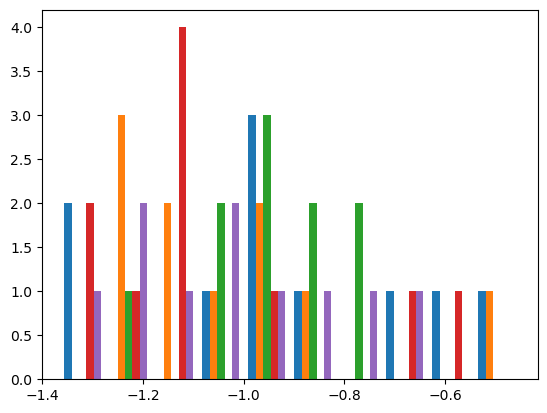

In [73]:
## predict on val dataset 

print('q_z_mean:')
print(q_z_kg_tmp_test.mean())

plt.hist(q_z_kg_tmp_test)
# plt.scatter(val_dataset.counts.flatten(), pred_val_counts_ng.detach().numpy().flatten())
# plt.title('counts correlation')
# plt.xlabel('true counts')
# plt.ylabel('predicted counts')

### Test get parameters method

In [76]:
print("gr cov:")
param_df = gr_cov.get_params()
print(param_df.head())

print("gr baseline:")
param_baseline_df = gr_baseline.get_params()
print(param_baseline_df.head())

gr cov:
     beta_1    beta_2    beta_3    beta_4    beta_5    beta_0 cell_type gene
0 -1.925288  0.880752 -2.234416 -1.765734 -0.283066 -1.157336         0    0
1 -1.242555 -0.777489 -0.683833 -3.103028 -0.823624 -1.330475         0    1
2  0.197054 -0.161946 -0.993158 -1.338703 -1.851053 -0.881121         0    2
3 -1.254536 -1.515761 -0.742005  1.009926 -0.115096 -0.688439         0    3
4 -0.486095 -1.190681 -2.661070 -1.530223 -1.988146 -1.580257         0    4
gr baseline:
     beta_0 cell_type gene
0 -2.069431         0    0
1 -2.562579         0    1
2 -1.627157         0    2
3 -1.161221         0    3
4 -3.083243         0    4
